In [1]:
import pandas as pd
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
import itertools as it

pd.options.display.max_rows = 20
plt.rcParams.update({'font.size':20})

In [2]:
BTR = pd.read_csv("bbm-true-prototype.csv")
BTR.columns = ["name", "n", "sdsize", "sddepth", "att", "maa", "mintrap"]
BTR = BTR.sort_values(by=["name"])
BTR = BTR.dropna(subset=['sdsize','sddepth'])

BTR

,name,n,sdsize,sddepth,att,maa,mintrap
0,001.bnet,321.0,1.0,0.0,1.0,0.0,1.0
2,003.bnet,20.0,1.0,0.0,1.0,0.0,1.0
4,005.bnet,28.0,7.0,4.0,1.0,0.0,1.0
5,006.bnet,68.0,1.0,0.0,1.0,0.0,1.0
6,007.bnet,5.0,3.0,1.0,2.0,0.0,2.0
...,...,...,...,...,...,...,...
207,208.bnet,15.0,14.0,4.0,5.0,0.0,5.0
208,209.bnet,87.0,2.0,1.0,1.0,0.0,1.0
209,210.bnet,144.0,2.0,1.0,1.0,0.0,1.0
210,211.bnet,183.0,3.0,2.0,1.0,0.0,1.0


In [3]:
BID = pd.read_csv("bbm-identity-prototype.csv")
BID.columns = ["name", "n", "sdsize", "sddepth", "att", "maa", "mintrap"]
BID = BID.sort_values(by=["name"])
BID = BID.dropna(subset=['sdsize','sddepth'])

In [4]:
RAN = pd.read_csv("random-prototype.csv")
RAN.columns = ["name", "n", "sdsize", "sddepth", "att", "maa", "mintrap"]
RAN = RAN.sort_values(by=["name"])
RAN = RAN.dropna(subset=['sdsize','sddepth'])

In [5]:
class PlotVar:
    _label_dict = {
        "n": r"network size",
        "sdsize": r"SD size",
        "sddepth": r"SD depth",
        "att": r"number of attractors",
        "maa": r"number of motif avoidant attractors",
        "mintrap": r"number of minimal trapspaces",
    }

    def __init__(self, data:pd.DataFrame, name: str, minval: float, maxval: float, log:bool=False, trend:bool=False):
        self.data = data
        self.name = name
        self.minval = minval
        self.maxval = maxval
        self.label = self._label_dict[name]
        self.log = log
        self.trend = trend

In [28]:
def monoExp(x, t):
    return np.exp(t * x)

def line(x, t):
    return t * x

def comparison_plots(vars, hlines=None, vlines=None):
    icount = len(vars)
    jcount = len(vars[0])

    fig = plt.figure(figsize=(10 * jcount, 10 * icount))
    fig.set_facecolor("white")

    figs = fig.subfigures(icount, jcount)
    figs = np.reshape(
        figs, (icount, jcount)
    )  # always treat as 2d array, even when only 1 col or row

    for i, j in it.product(range(icount), range(jcount)):
        px, py = vars[i][j]
        data = px.data        
        vx, vy = px.name, py.name
        xmin, xmax = px.minval, px.maxval  # lims[i][j][0]
        ymin, ymax = py.minval, py.maxval  # lims[i][j][1]
        xlog, ylog = px.log, py.log
        ytrend = py.trend
    
        axd = figs[i, j].subplots(1,1)
        axd.set_zorder(10)

        if hlines:
            axd.hlines(hlines, xmin, xmax, color="k", linestyle="-.")
        if vlines:
            axd.vlines(vlines, ymin, ymax, color="k", linestyle="-.")
        if xlog:
            axd.set_xscale('log')
        if ylog:
            axd.set_yscale('log')
        if ytrend:
            xs = data[vx].sort_values()
            ys = data[vy].sort_values()

            # direct fit
            p0 = (0.7) # start with values near those we expect
            params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, p0)
            t = params[0]
            # determine quality of the fit
            squaredDiffs = np.square(ys - monoExp(xs, t))
            squaredDiffsFromMean = np.square(ys - np.mean(ys))
            rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
            print(f"direct fit: R² = {rSquared}")
            # plot the results
            xs1 = np.arange(xmin,xmax, 0.1)
            axd.plot(xs1, monoExp(xs1, t), '--', label="fitted_scipy")
            # inspect the parameters
            print(f"direct fit: Y = e^({t} * x)")

            axd.annotate(
                f"Y = e^({round(t,2)} * x)\nR² = {round(rSquared,3)}",
                xy=(0.2, 0.9),
                xycoords = 'axes fraction',
                ha="center",
                va="center",
                c='#1f77b4'
            )

            # fit to log
            p0 = (0.7) # start with values near those we expect
            params, cv = scipy.optimize.curve_fit(line, xs, np.log(ys), p0)
            t = params[0]
            # determine quality of the fit
            squaredDiffs = np.square(ys - monoExp(xs, t))
            squaredDiffsFromMean = np.square(ys - np.mean(ys))
            rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
            print(f"log fit: R² = {rSquared}")
            # plot the results
            xs1 = np.arange(xmin,xmax, 0.1)
            axd.plot(xs1, monoExp(xs1, t), '--', label="fitted_scipy")
            # inspect the parameters
            print(f"log fit: Y = e^({t} * x)")

            axd.annotate(
                f"Y = e^({round(t,2)} * x)\nR² = {round(rSquared,3)}",
                xy=(0.2, 0.8),
                xycoords = 'axes fraction',
                ha="center",
                va="center",
                c='#ff7f0e'
            )

        axd.scatter(data[vx], data[vy],
            s=100,
            alpha=0.3,
            zorder=10,
            clip_on=False,
        )
        
        axd.set_xlabel(px.label)
        axd.set_ylabel(py.label)
        axd.set_xlim(xmin, xmax)
        axd.set_ylim(ymin, ymax)

        figs[i, j].subplots_adjust(hspace=0.0135, wspace=0.0135)
    fig.subplots_adjust(bottom=0.08, left=0.05)
    return fig

C:\Users\danie\AppData\Local\Temp\ipykernel_2088\694034757.py:83: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axd.set_ylim(ymin, ymax)


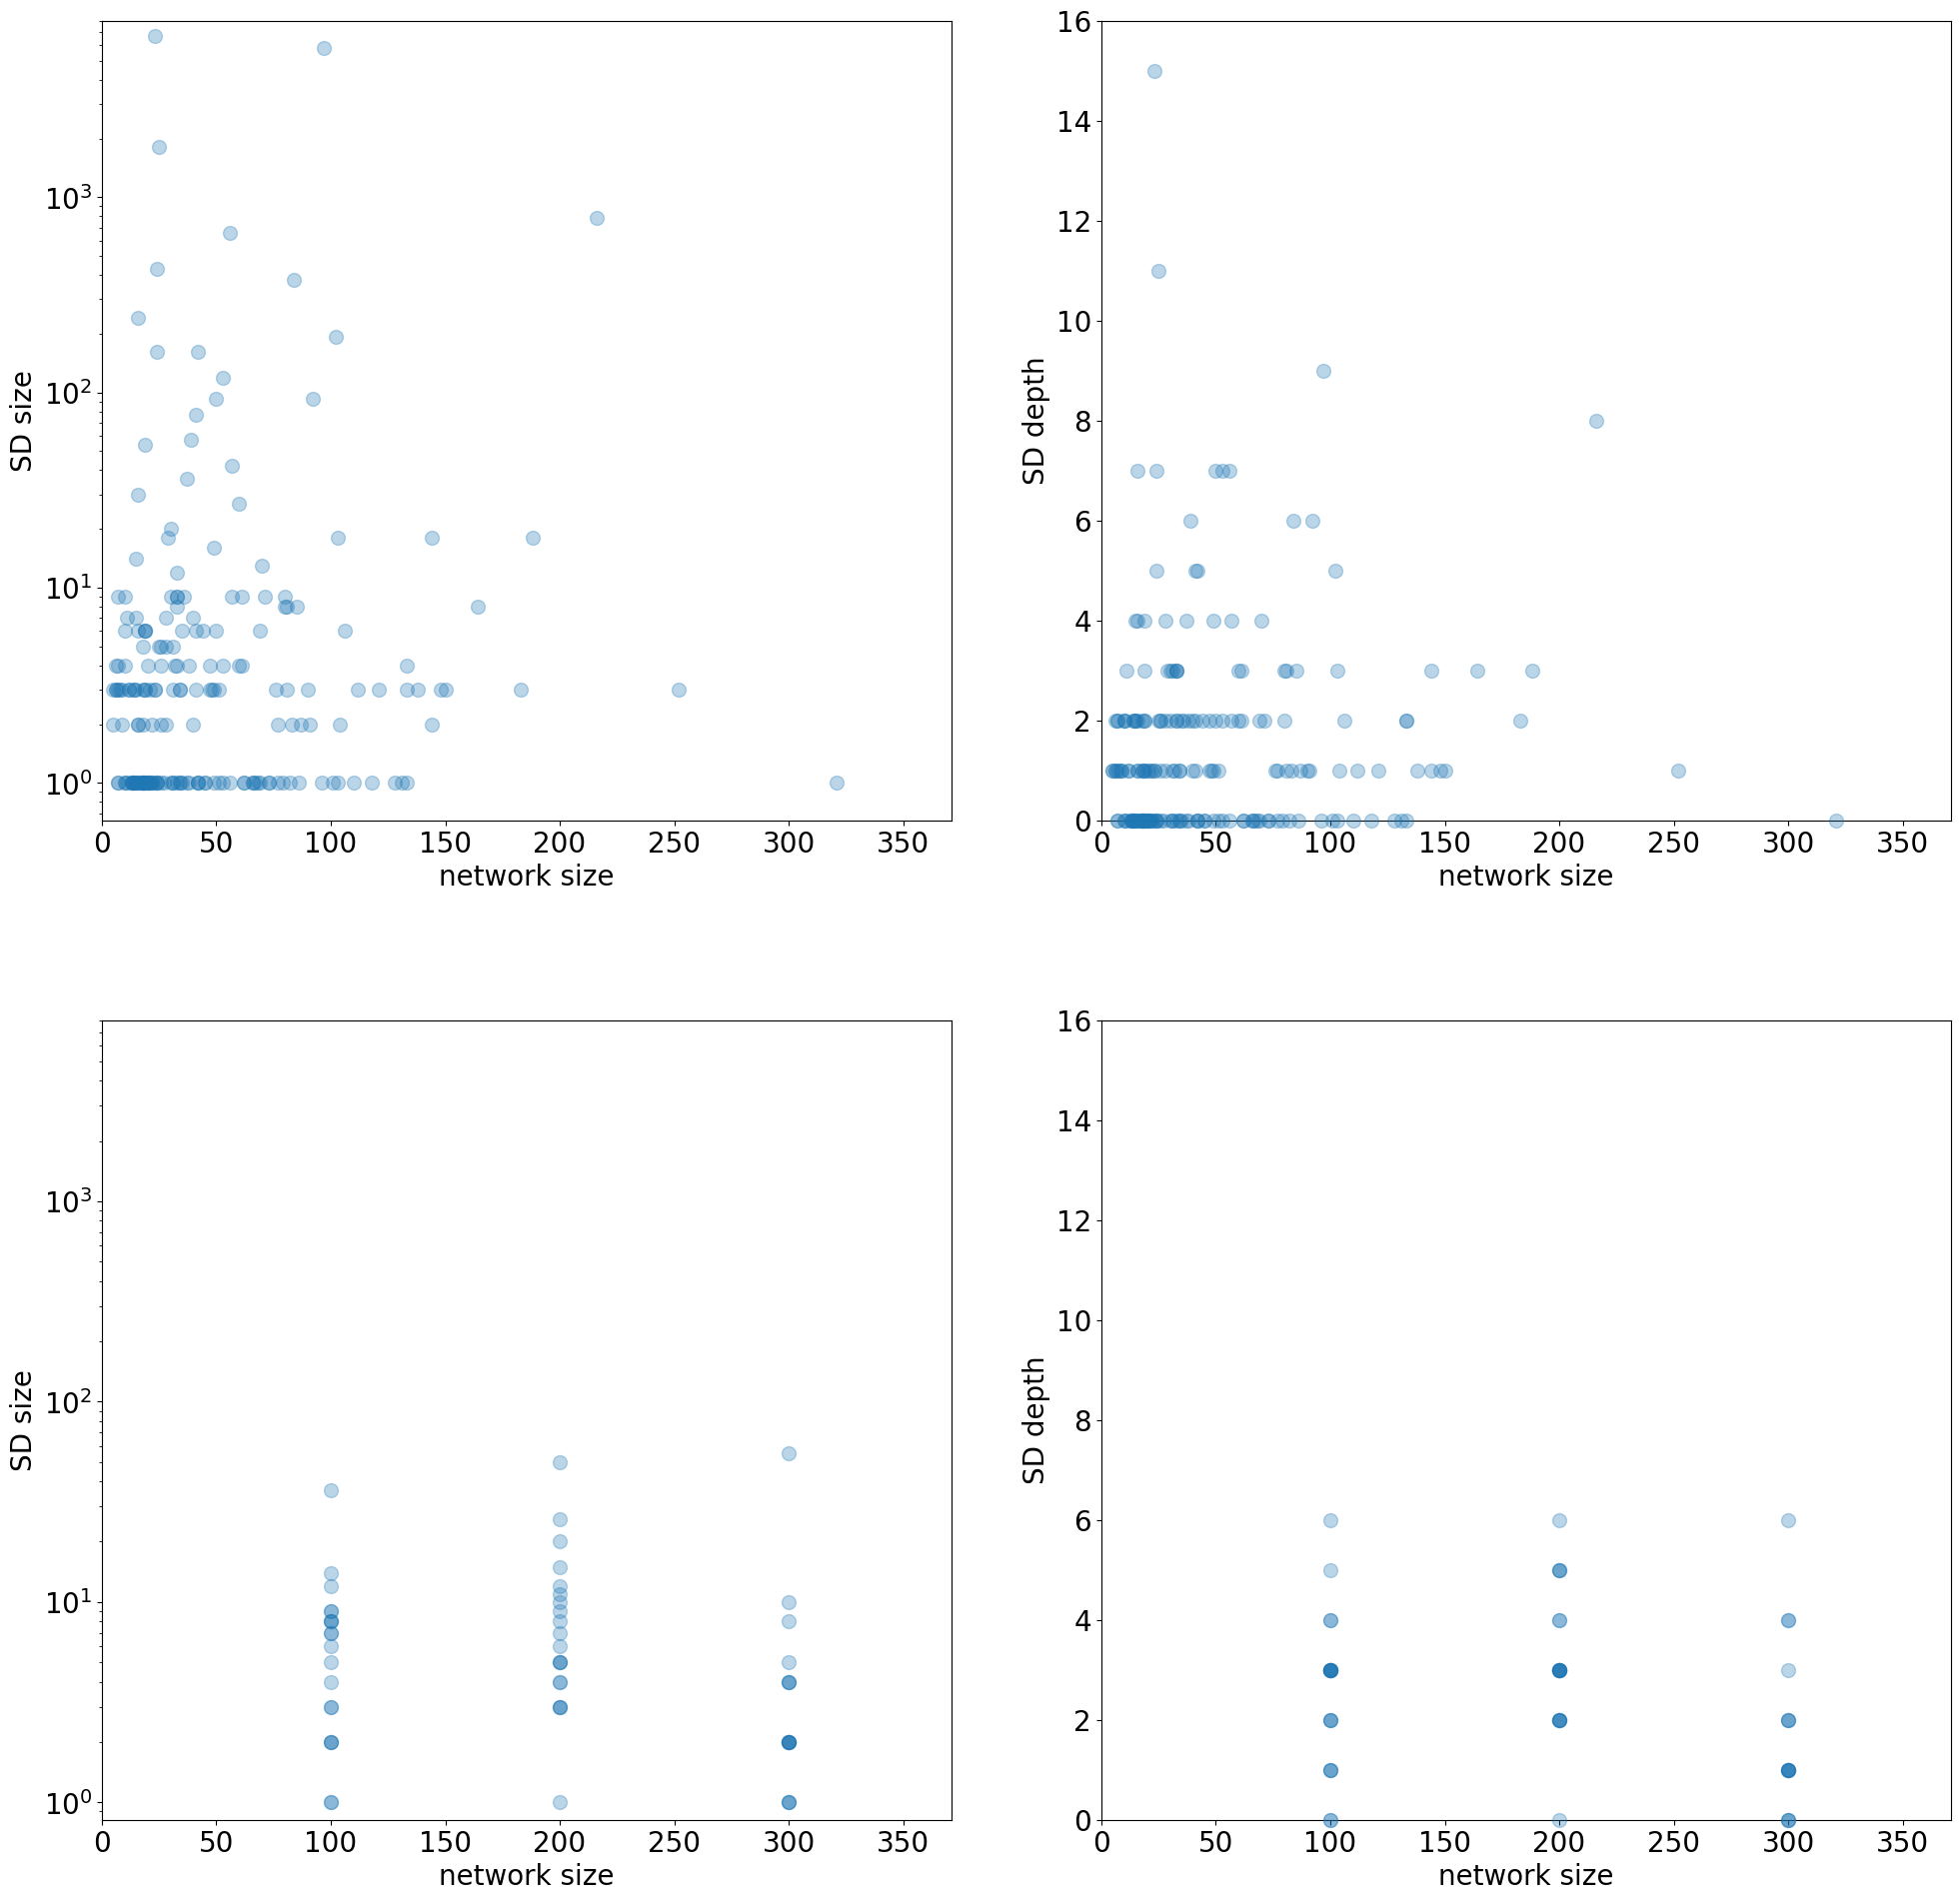

In [11]:
vars = [
    [
        (
            PlotVar(BTR,"n",0,BTR["n"].max()+50),
            PlotVar(BTR,"sdsize",0,BTR["sdsize"].max()*1.2,True),
        ),
        (
            PlotVar(BTR,"n",0,BTR["n"].max()+50),
            PlotVar(BTR,"sddepth",0,BTR["sddepth"].max()+1),
        ),
    ],
    [
        (
            PlotVar(RAN,"n",0,BTR["n"].max()+50),
            PlotVar(RAN,"sdsize",0,BTR["sdsize"].max()*1.2,True),
        ),
        (
            PlotVar(RAN,"n",0,BTR["n"].max()+50),
            PlotVar(RAN,"sddepth",0,BTR["sddepth"].max()+1),
        ),
    ],
]

fig = comparison_plots(vars)

direct fit: R² = 0.5804859755803566
direct fit: Y = e^(0.5909769551630191 * x)
log fit: R² = -231.18164082644734
log fit: Y = e^(0.7920002773064526 * x)
direct fit: R² = 0.5804859755803566
direct fit: Y = e^(0.5909769551630191 * x)
log fit: R² = -231.18164082644734
log fit: Y = e^(0.7920002773064526 * x)
direct fit: R² = 0.8069120903174982
direct fit: Y = e^(0.6297069280748969 * x)
log fit: R² = 0.8084177744756234
log fit: Y = e^(0.6163580650056952 * x)
direct fit: R² = 0.8069120903174982
direct fit: Y = e^(0.6297069280748969 * x)
log fit: R² = 0.8084177744756234
log fit: Y = e^(0.6163580650056952 * x)


C:\Users\danie\AppData\Local\Temp\ipykernel_2088\3416126802.py:101: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axd.set_ylim(ymin, ymax)


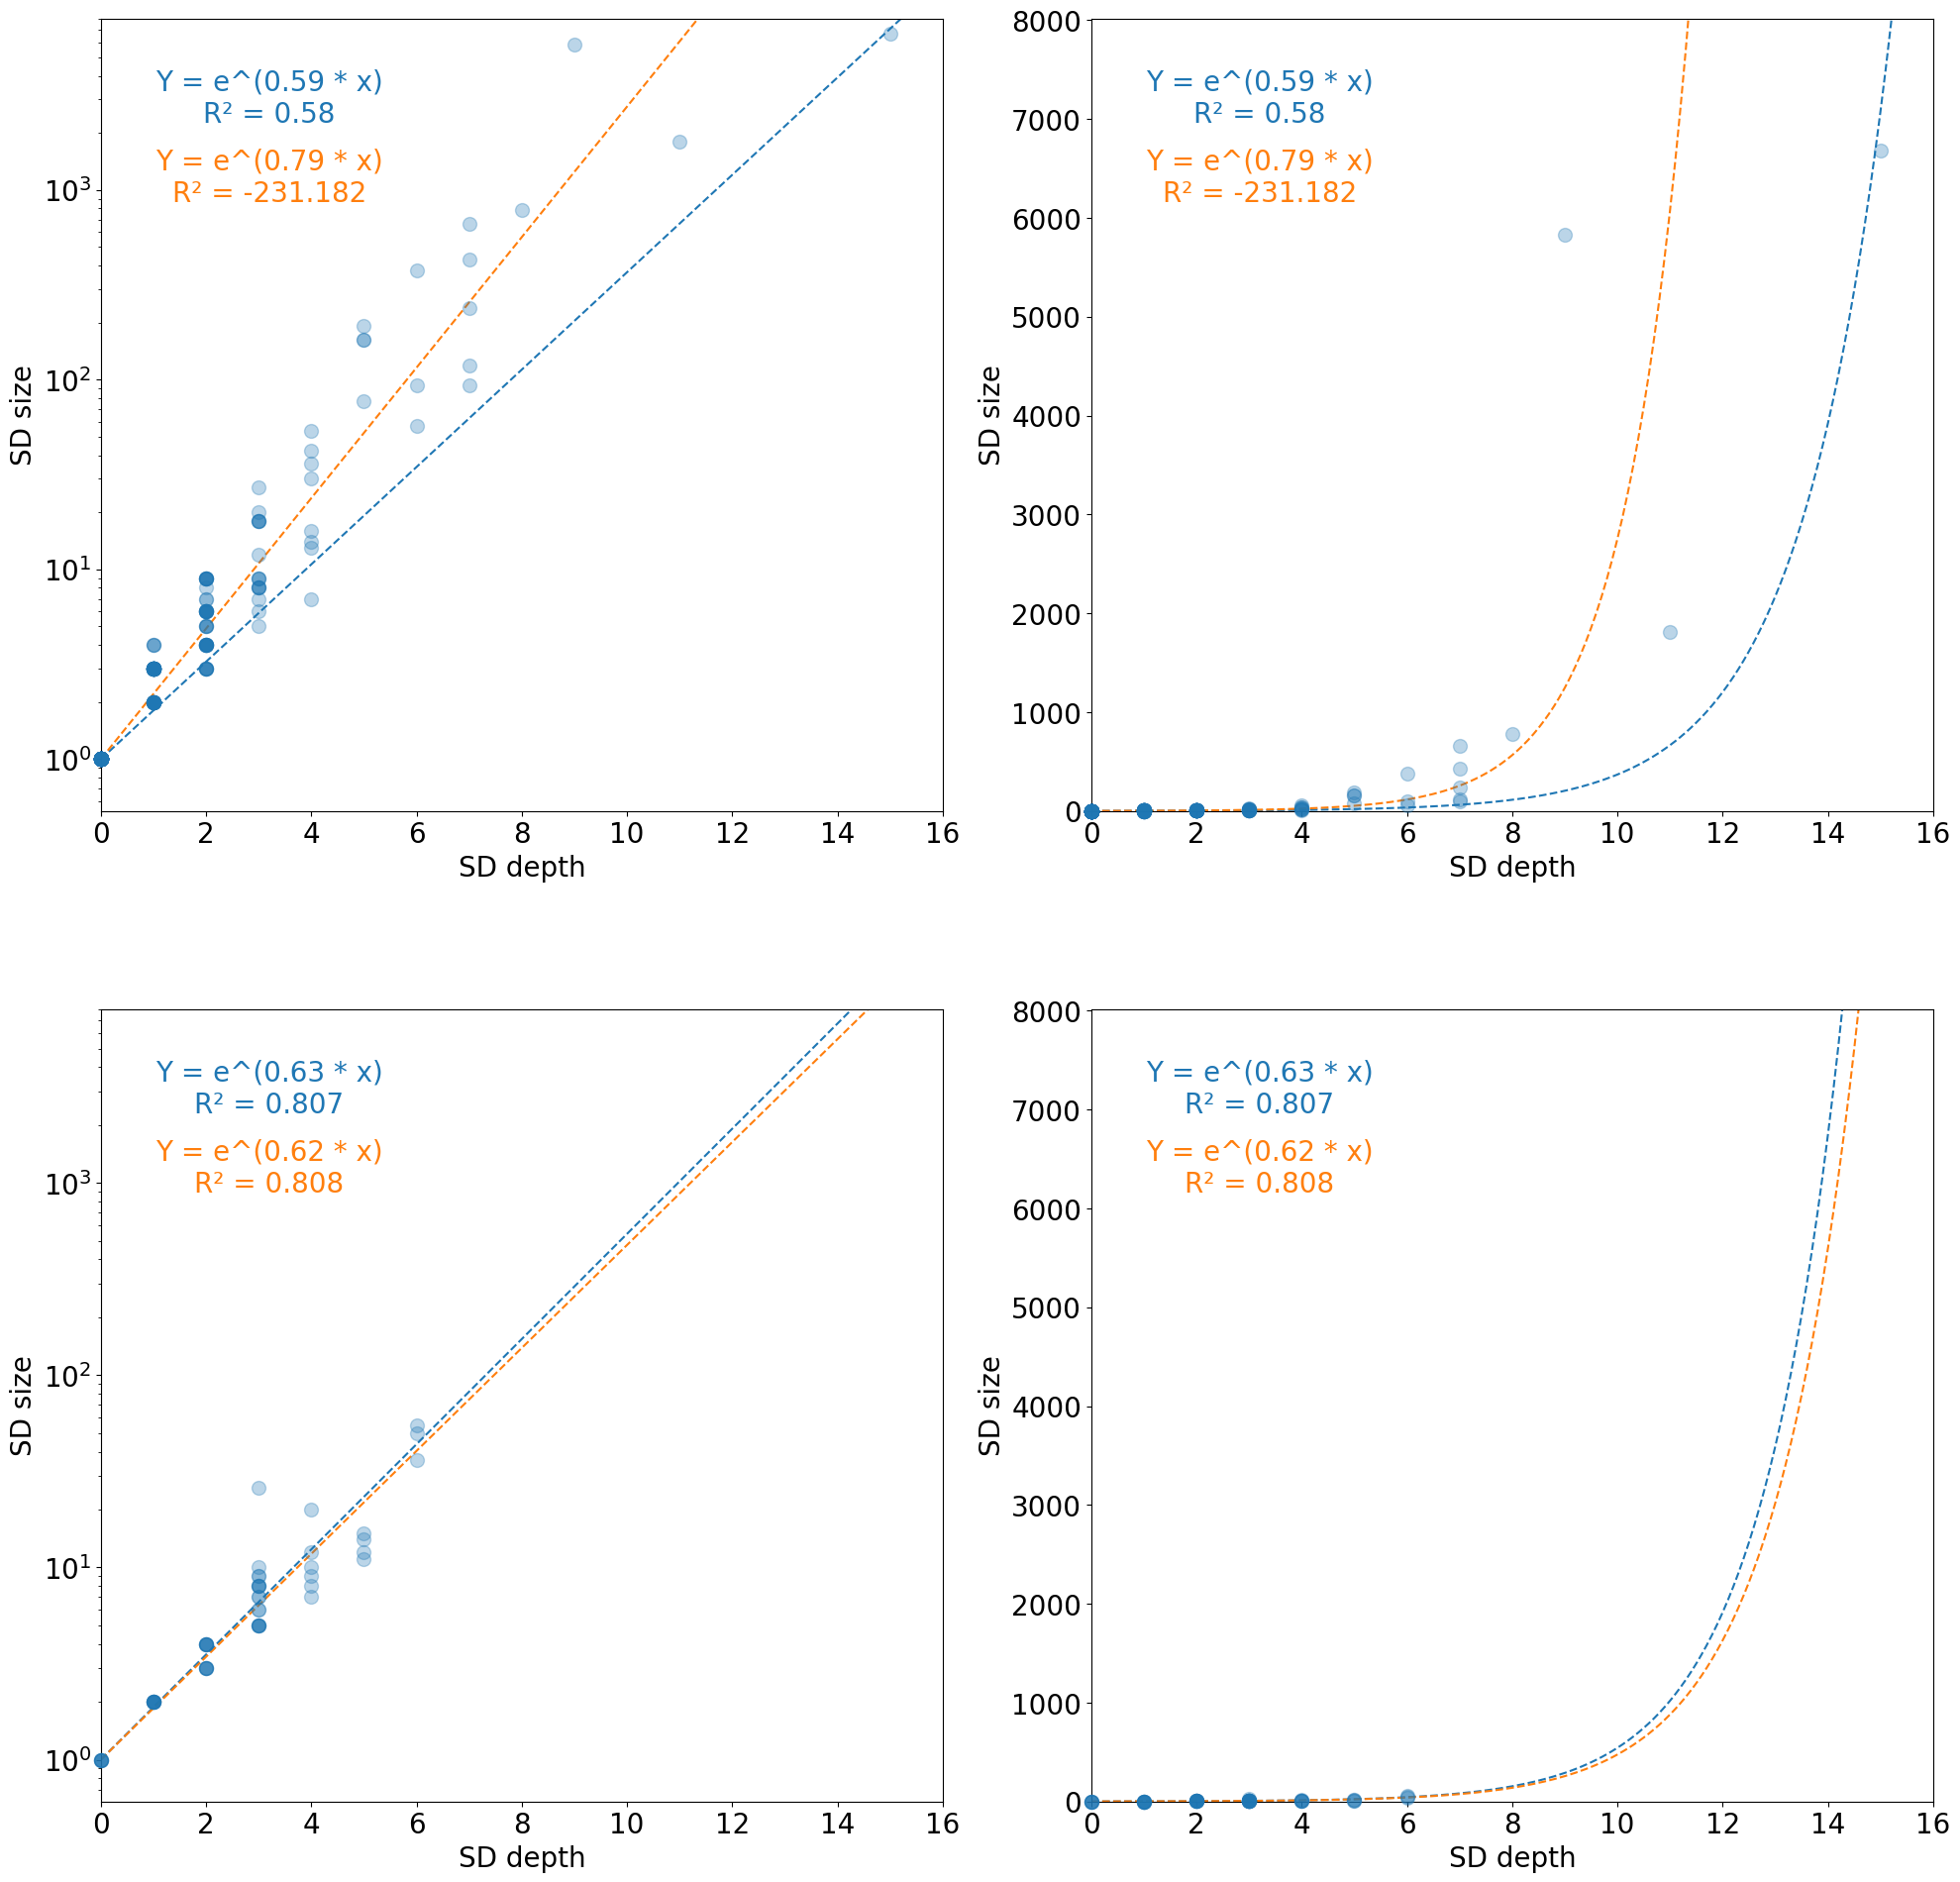

In [29]:
vars = [
    [
        (
            PlotVar(BTR,"sddepth",0,BTR["sddepth"].max()+1),
            PlotVar(BTR,"sdsize",0,BTR["sdsize"].max()*1.2,True,True),
        ),
        (
            PlotVar(BTR,"sddepth",0,BTR["sddepth"].max()+1),
            PlotVar(BTR,"sdsize",0,BTR["sdsize"].max()*1.2,False,True),
        ),
    ],
    [
        (
            PlotVar(RAN,"sddepth",0,BTR["sddepth"].max()+1),
            PlotVar(RAN,"sdsize",0,BTR["sdsize"].max()*1.2,True,True),
        ),
        (
            PlotVar(RAN,"sddepth",0,BTR["sddepth"].max()+1),
            PlotVar(RAN,"sdsize",0,BTR["sdsize"].max()*1.2,False,True),
        ),
    ],
]

fig = comparison_plots(vars)